In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)
measurement_df.head()



,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [7]:

Hawaii_station_df = pd.read_sql('SELECT * FROM station', conn)
Hawaii_station_df.head()


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Part 2 - Exploratory Climate Analysis

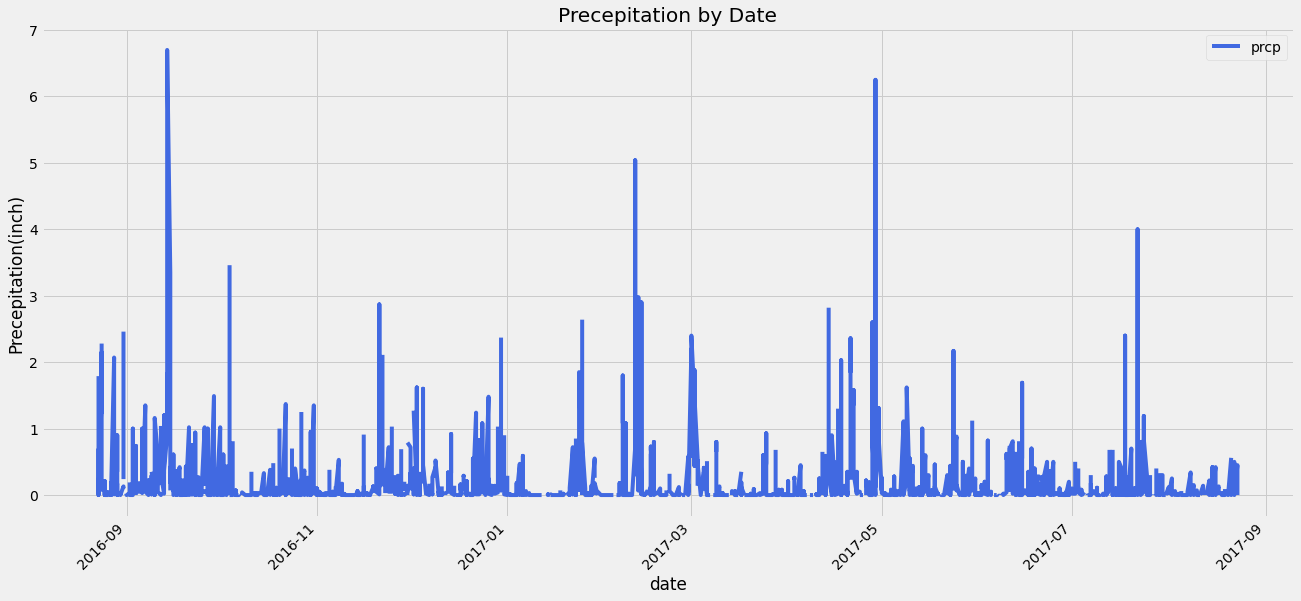

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date


query= f'''
    SELECT 
        date, 
        prcp
    FROM 
        measurement
    WHERE
        date >= (SELECT DATE (max (date), "-1 year") FROM measurement)
    ORDER BY date DESC
'''


precipitation_df = pd.read_sql(query, conn)
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

precipitation_df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(color="royalblue", figsize=(20, 10), rot=45)
plt.title('Precepitation by Date')
plt.ylabel('Precepitation(inch)')
plt.savefig('precepitation.png')
plt.show()


In [9]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?
pd.read_sql('SELECT COUNT ( * ) AS "Stations Count" FROM station', conn)



,Stations Count
0,9


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = f'''
    SELECT 
        s.station AS "Station code",
        s.name AS "Station Name",
        COUNT(*) as "Station Count"
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    GROUP BY
        s.station,
        s.name
    ORDER BY
        "Station Count" DESC,
        "Station Name"
        


'''
active_station_df = pd.read_sql(query, conn)
active_station_df.head()

,Station code,Station Name,Station Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_df.sort_values('Station Count', ascending=False, inplace=True)
top_active_station = active_station_df['Station code'].values[0]

query = f'''
SELECT
    MIN(tobs) AS min_tobs,
    MAX(tobs) AS max_tobs,
    AVG(tobs) AS avg_tobs
FROM
    measurement
Where
    station = '{top_active_station}'
'''

top_station_temp = pd.read_sql(query, conn)
top_station_temp

,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


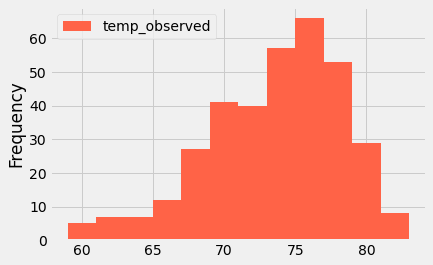

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


query = f'''
    SELECT
        date,
        tobs AS temp_observed
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date),'-1 year') FROM measurement)
        AND station = '{top_active_station}'
    '''
temp_obs_df = pd.read_sql(query, conn)
temp_obs_df

temp_obs_df.plot.hist(bins=12, color='tomato')



## Part 3 - Data Analysis Assignment

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
        SELECT
            MIN(tobs) ,
            MAX(tobs) ,
            AVG(tobs)
        FROM
            measurement 
        WHERE 
            date BETWEEN '{start_date}' AND '{end_date}'

    '''
    temp_stats_df = pd.read_sql(query, conn)
    return temp_stats_df


# function usage example
print(calc_temps('2017-01-09', '2017-01-24'))

   MIN(tobs)  MAX(tobs)  AVG(tobs)
0       62.0       81.0  70.575758


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    query = f''' 
    
        SELECT
            MIN(tobs) AS min_temp,
            MAX(tobs) AS max_temp,
            AVG(tobs) AS avg_tem
        FROM
            measurement 
        WHERE 
            date BETWEEN '{start_date}' AND '{end_date}'
        '''

    temp_stats_df = pd.read_sql(query, conn)
    return temp_stats_df
print(calc_temps('2016-01-09', '2016-01-24'))


   min_temp  max_temp    avg_tem
0      61.0      78.0  69.526882


<ipython-input-64-858f1bc85916>:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.bar(trip_dura, avg_temp, max_temp, yerr=y_error,alpha=0.6, color="springgreen")


<Figure size 720x1080 with 0 Axes>

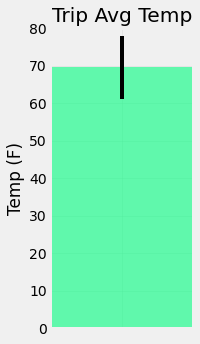

In [64]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_dura = '2016-01-09 to \n 2016-01-24'
start_date = '2016-01-09'
end_date = '2016-01-24'
trip_temp_stat = calc_temps('2016-01-09', '2016-01-24')
trip_temp_stat
min_temp = trip_temp_stat['min_temp']
max_temp = trip_temp_stat['max_temp']
avg_temp = trip_temp_stat['avg_tem']
min_erro = avg_temp - min_temp
max_erro = max_temp - avg_temp

plt.figure(figsize=(10, 15))
y_error = np.array([[min_erro ], [max_erro]])
fig, ax = plt.subplots(figsize = (3, 5))
plt.bar(trip_dura, avg_temp, max_temp, yerr=y_error,alpha=0.6, color="springgreen")

plt.xlim(-1.5,1.5)
plt.ylim(0,80)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tight_layout()
plt.grid(alpha =.3)



In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = f'''
    SELECT
       measurement.station,
        s.name,
       prcp_sum,
      
       s.latitude,
       s.longitude,
       s.elevation
       
    FROM
        (SELECT 
            station,
            ROUND(sum(prcp),2) AS 'prcp_sum',
            prcp  
        FROM 
            measurement 
        WHERE date BETWEEN "2016-01-09" and "2016-01-24" 
        GROUP BY 
            station) 
    measurement 
    INNER JOIN station s 
    ON measurement.station=s.station 
    ORDER BY measurement.prcp desc
     
        
 '''
rainfall_df = pd.read_sql(query, conn)
rainfall_df

,station,name,prcp_sum,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",0.05,21.27160,-157.81680,3.0
1,USC00519281,"WAIHEE 837.5, HI US",0.56,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.40,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.80,21.52130,-157.83740,7.0
4,USC00517948,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.39,21.33556,-157.71139,19.5
6,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.11,21.33310,-157.80250,152.4


In [76]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """

    # your code here
    query = f'''
    SELECT 
        min(tobs) AS min_temp,
        ROUND(avg(tobs), 2) AS avg_temp,
        max(tobs) AS max_temp
    FROM 
        measurement 
    WHERE 
        date like "%01-%01"
    '''
    daily_temp = pd.read_sql(query, conn)
    return daily_temp
    
daily_normals("01-01")

,min_temp,avg_temp,max_temp
0,62.0,69.15,77.0


In [ ]:
startdate = '2018-01-01'
enddate = '2018-01-07'

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

strtdt = dt.datetime.strptime(start_date, '%Y-%m-%d')
enddt = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dura = []
normals =[]
while (strtdt <= enddt):
    append.trip_dura(dtobj)
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = '2016-01-09'
end_date = '2016-01-24'
dates = pd.date_range(start_date, end_date).tolist()
strtdt = dt.datetime.strptime(start_date, '%Y-%m-%d')
trip_dura =[]
for date in dates:
    trip_dura.append (dt.datetime.strftime(date, '%m-%d')) 
normals=[]
for trip in trip_dura:
    normals.append(daily_normals(date))
for normal in normals:
    print(normal)

   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      62.0     69.15      77.0
   min_temp  avg_temp  max_temp
0      6

In [88]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_temp=[]
for normal in normals:
    normal_temp.append(np.ravel(normal))
trip_df = pd.DataFrame(normal_temp, columns=['min(tobs)', 'avg(tobs)', 'max(tobs)'])
trip_df.index=[str(date.strftime('%Y-%m-%d')) for date in trip_list]
trip_df

,min(tobs),avg(tobs),max(tobs)
2016-01-09,62.0,69.15,77.0
2016-01-10,62.0,69.15,77.0
2016-01-11,62.0,69.15,77.0
2016-01-12,62.0,69.15,77.0
2016-01-13,62.0,69.15,77.0
2016-01-14,62.0,69.15,77.0
2016-01-15,62.0,69.15,77.0
2016-01-16,62.0,69.15,77.0
2016-01-17,62.0,69.15,77.0
2016-01-18,62.0,69.15,77.0


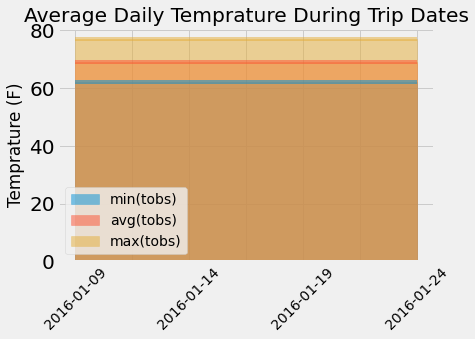

In [89]:
# Plot the daily normals as an area plot with `stacked=False`

ax = trip_df.plot.area(stacked=False, rot=45)
plt.yticks(size=20)
plt.ylabel("Temprature (F)")
plt.title("Average Daily Temprature During Trip Dates")
plt.show()
